In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
def code_cat_cols(X, cat_cols):
    return X[cat_cols].astype(str).astype('category').apply(lambda x: x.cat.codes)


def scale_num_cols(X, num_cols):
    return pd.DataFrame(StandardScaler().fit_transform(X[num_cols]), columns=num_cols).fillna(0).apply(np.float32)

def find_cat_num_cols(X):
    cat_cols = X.select_dtypes(exclude=["number","bool_"]).columns
    num_cols = list(set(X.columns) - set(cat_cols))
    return cat_cols, num_cols


def full_preprocess(X):
    cat_cols, num_cols = find_cat_num_cols(X)
    return pd.concat([code_cat_cols(X, cat_cols), scale_num_cols(X, num_cols)], axis=1)

Построим модель на основе результатов пятой недели

In [3]:
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier


X = pd.read_csv('data/orange_small_churn_data.train.csv')
y = pd.read_csv('data/orange_small_churn_labels.train.csv', header=None)

X_dropped = X.dropna(axis=1, thresh=20_000, how="any") 
X_processed = full_preprocess(X_dropped)

X_new, _, y_new, _ = train_test_split(X_processed, y, train_size=17_000)
X_resampled, y_final = EditedNearestNeighbours().fit_resample(X_new, y_new)

rf = RandomForestClassifier().fit(X_resampled, y_final)
m = SelectFromModel(rf, prefit=True)
X_final = m.transform(X_resampled)

model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=2, verbosity=0)
model.fit(X_final, y_final);

In [4]:
from sklearn.model_selection import cross_val_score


print(cross_val_score(model, X_final, y_final, scoring='roc_auc', cv=5).mean())

0.7105966562396812


- сколько денег в среднем приносит один пользователь в месяц  
- сколько денег в среднем вы будете вкладывать в удержание одного пользователя 
- с какой вероятностью пользователь примет ваше предложение 
- сколько пользователей будет участвовать в кампании 

In [60]:
def effect(df, t, rpc, ret_cost, p):
    num_clients = int(df.shape[0] * t)
    true_positive = df.iloc[:num_clients].iloc[0].sum()
    costs = num_clients * ret_cost 
    revenue = num_clients * p * rpc 
    return revenue - costs


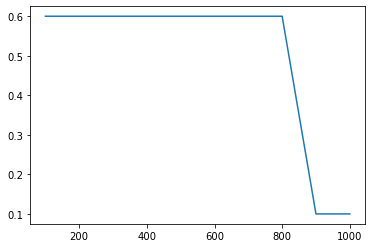

In [74]:
import matplotlib.pyplot as plt


ret_costs = np.arange(100, 1100, 100)
top = np.arange(0.1, 0.7, 0.1)
effects = []
tops = []
for ret_cost in ret_costs:
    effects = np.array([[effect(y, t, 2000, ret_cost, 0.4), t] for t in top])
    tops.append(effects[effects[:, 0].argsort()][-1][1])
plt.plot(ret_costs, tops);

видно, что чем выше стоимость удержания, тем меньше оптимальный размер топа

4. Всегда ли применение модели экономически оправданно? Приведите пример набора значений параметров, при которых применение модели перестает быть оправданным.

не всегда. Применение модели не оправдано, если стоимость удержания пользователя превышает доход от него

6. Как вы думаете, является ли экономически оправданным вложение средств в улучшение качества модели? На сколько нужно улучшить модель, чтобы это качественно сказалось на экономическом эффекте от удержания?

вложение средств является экономически оправданным, если увеличение экономического эффекта превышает вложения